# Build knowledge graph via deep learning

Authors:
* Xiaoyuan Liu
* Neel Kovelamudi
* Zijian Xie
* Mu He
* Cuiqianhe Du
* Nicholas Lin
* Austin Wei

Principal Investigator: 
* Dawn Song

Date: Fall 2021

References: 
[Knowledge Graph & NLP Tutorial-(BERT,spaCy,NLTK)](https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook)

### Pipeline: 
Datasource -> Data cleaning -> entity/relation extraction -> application

### Import library

In [1]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import bs4
import requests
import spacy
import string
import demoji
import os
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

### Whitepaper datasource

In [2]:
def read_whitepapers(filename):
    directory = "../whitepapers"
    texts = []
    for entry in os.scandir(directory):
        if (entry.path.endswith(filename) and entry.is_file()):
            a_dataframe = pd.read_csv(entry.path, names=[filename], sep="\n")
    a_dataframe.replace('', np.nan, inplace=True)
    a_dataframe.dropna(inplace=True)
    return a_dataframe

In [3]:
shiba_filename = "shiba_inu.txt"
shiba_whitepapers = read_whitepapers(shiba_filename)
shiba_whitepapers

,shiba_inu.txt
0,SHIBA INU
1,ECOSYSTEM
2,WWW.SHIBATOKEN.COM
3,BONE
4,v1 - 4/29/21 - WOOF Paper
...,...
209,"participation, none of this would be possible."
210,It's time for us to begin.
211,- Ryoshi
212,v1 - 4/29/21 - WOOF Paper WWW.SHIBATOKEN.COM


In [4]:
# import wikipedia sentences
candidate_sentences = pd.read_excel("./input/dataset_twitter-scraper_2021-11-22_22-28-52-216.xlsx")
candidate_sentences['full_text'].sample(5)

56     Third Airdrop Event is LİVE now. \nWe will distribute 100.000 $SIRI per person. \nTotal amount for Airdrop 4.000.000 $SIRI \nFirst 20 people will be eligible to have $SIRI\nFurther information is ...
170    #QuarashiNetwork #Wallet, the All In One app you've been waiting for your #cryptocurrency \n\nDOWNLOAD NOW\n\n✅https://t.co/V1HW98voXL\n\n@0xPolygon @BinanceChain #Ethereum #BNB #Polygon #BSC #qua...
120    @MicheleN918 @Honest_Mike_ Welcome! If you ever need #VGXhero connections, they’re on my profile, @VGX_Floki, @UTSnakeyes, and @VGX_heroes official twitter page. Give us a follow to stay in the lo...
38                                                                                                              BREAKING: Odell Beckham Jr will receive 100% of his salary in #Bitcoin https://t.co/UiBFtdjASG
114                                                                                     MY FIRST #NFT \n\n✔️ ONLY 100 PIECES\n✔️ ONLY 0.025 ETH\n\nFOR BUY \n\nhttps://t.co/

### Data cleaning/preprocessing
We will begin our data processing with punctuations

In [5]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

In [6]:
def tweet_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
#     text = str(text).lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = remove_emojis(text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

In [7]:
candidate_sentences['full_text']=candidate_sentences['full_text'].apply(lambda x:tweet_cleaning(x))
candidate_sentences['full_text'].sample(5)

349                                                                                                                                       All in The Umee Blockchain UmeeCrossChain Umee Cosmos UmeeCrossChain
262    We are proud to announce President of El Salvador nayibbukele as a speaker at At Bitcoin Bukele announced plans to make bitcoin legal tender in El Salvador via video and will join the speaker line...
134    DEVOLUTION NFT based game “We build our Metaverse” Collect earn win and trade NFTs while playing amp socialising in a game that connects online players globally Featuring PVE amp PVP mode Players ...
236                                               Thanks for giving us such a great opportunity I am supporting it always success for the development team to the moon Chwench ccontpower Crypto Airdrops KILL
20                                                                                                                                                 BREAKING El Salvador Pres

### Extract entities
Extract entities from sentences

In [8]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

  #############################################################
  
    for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

### Entract relations
Extract relations from sentences

In [9]:
def get_relation(sent):
    if sent == '':
        return ''
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None)
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [10]:
def extract_entity_relation(candidate_sentences):
    candidate_sentences=candidate_sentences.apply(lambda x:tweet_cleaning(x))

    entity_pairs = []
    for i in tqdm(candidate_sentences):
        entity_pairs.append(get_entities(i))
    
    relation = [get_relation(i) for i in tqdm(candidate_sentences)]
    
    return entity_pairs, relation

bitcoin_entity_pairs, bitcoin_relation = extract_entity_relation(candidate_sentences['full_text'])
shiba_entity_pairs, shiba_relation = extract_entity_relation(shiba_whitepapers[shiba_filename])

100%|██████████| 214/214 [00:01<00:00, 197.90it/s]


In [11]:
def visualize_entity(entity_pairs):
    print(entity_pairs[10:20])
visualize_entity(shiba_entity_pairs)

[['We', 'spontaneous  community'], ['', ''], ['that', 'time'], ['', ''], ['Projects', 'community involvement'], ['we', 'financial  structures'], ['mindsets  we', 'new  one'], ['', ''], ['', 'communityrun projects'], ['change  they', 'radical  others']]


In [12]:
def visualize_relation(relations):
    print(pd.Series(relations).value_counts()[:50])
visualize_relation(shiba_relation)

WWWSHIBATOKENCOM        22
BONE                     8
are                      8
Minted per               6
get                      6
Share of                 6
                         5
SSLP                     4
SHIBASWAP                3
DIG                      3
been                     3
was                      3
is                       3
comes from               2
ECOSYSTEM                2
LEASH                    2
look                     2
work                     2
’s                       2
became                   2
SHIB                     2
from                     2
another                  1
WITH                     1
salute                   1
gathers of               1
aforementioned token     1
ETH                      1
CONCLUSION               1
throttled by             1
OF                       1
DAI                      1
DECENTRALIZATION         1
building                 1
receive                  1
earnest                  1
be                       1
o

### Build knowledge_graph
Build knowledge graph from entity and relation pairs

In [13]:
def build_knowledge_graph(entity_pairs, relations):
    # extract subject
    source = [i[0] for i in entity_pairs]

    # extract object
    target = [i[1] for i in entity_pairs]

    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    return kg_df
kg_bitcoin = build_knowledge_graph(bitcoin_entity_pairs, bitcoin_relation)
kg_shiba = build_knowledge_graph(shiba_entity_pairs, shiba_relation)

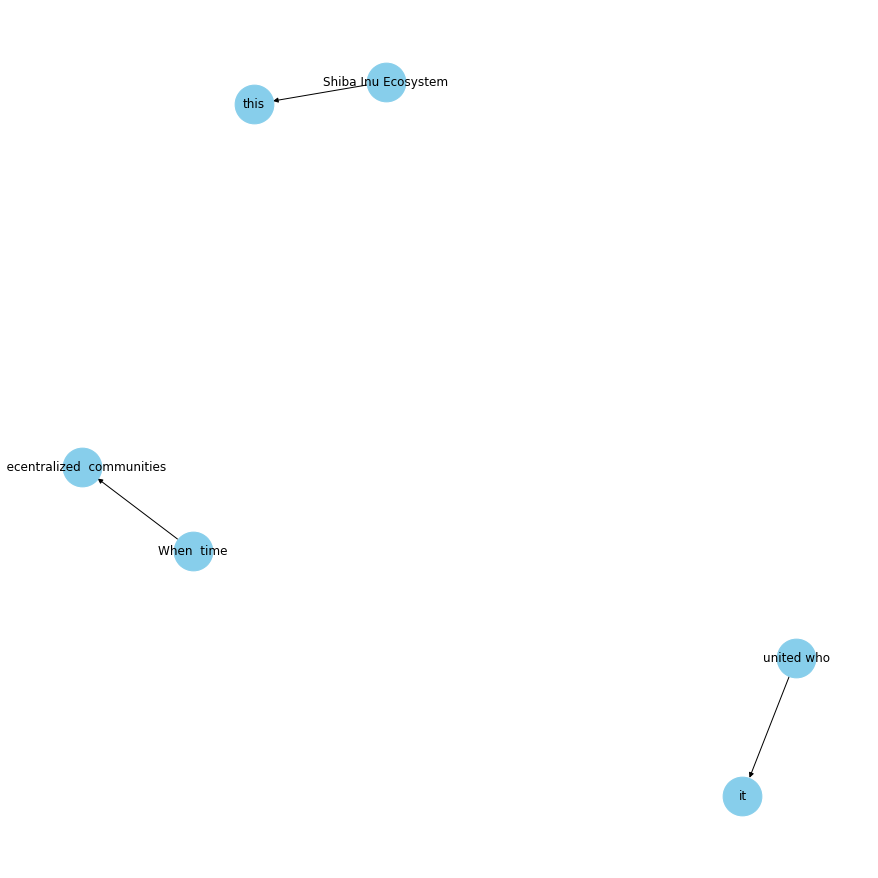

In [14]:
def visualize(kg_df, relation):
    G=nx.from_pandas_edgelist(kg_df[kg_df['edge']==relation], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()
    
visualize(kg_shiba, "is")

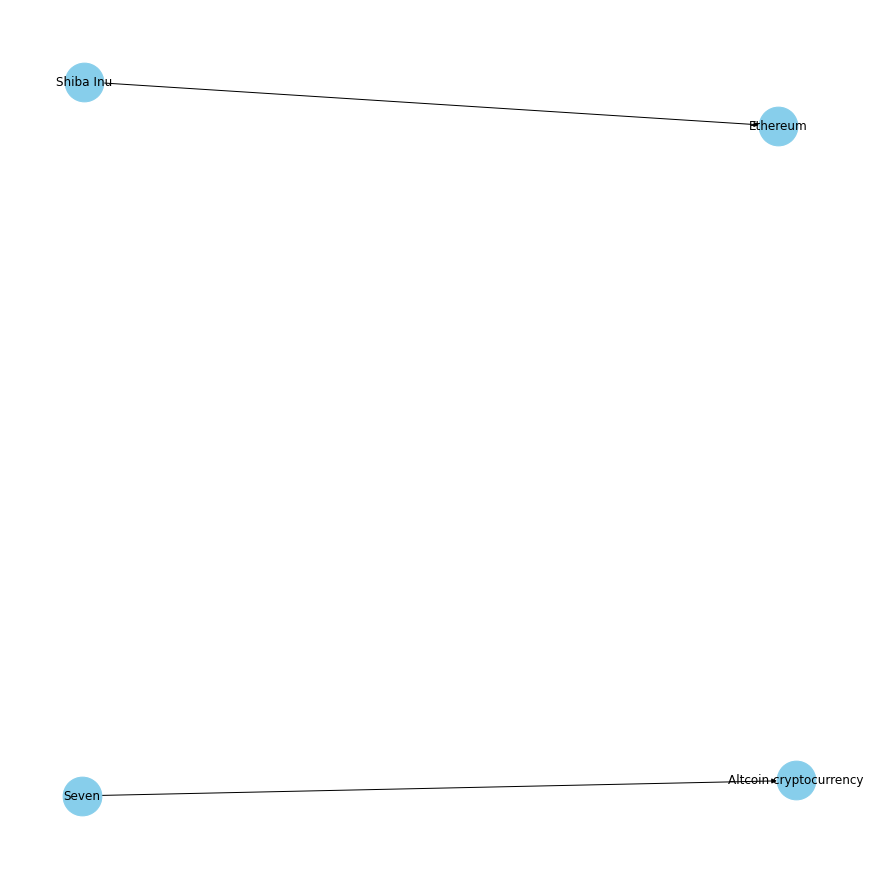

In [15]:
visualize(kg_bitcoin, 'altcoins')

In [16]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "My name is Wolfgang and I live in Berlin"

ner_results = nlp(example)
print(ner_results)

[{'entity': 'B-PER', 'score': 0.99901396, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]
